# **Background**

This competition has been a learning curve for me. Starting of with an implementation of FasterRCNN Resnet50 FPN model:

https://www.kaggle.com/shebinscaria/pytorch-resnet50fpn-gwd


# **What's new in this notebook ?**
This notebook is to experiment with different augmentations extended by albumentations package.
So what is new in the notebook which you have already not seen -
1. forumulate a framework for interactive implementation of augmentations
2. implementation of cut-out augmentation* with num_holes as one of the parameters
3. implementation of mosaic augmentation

The interactive framework is still experimental with some delays and constraints because I am still familiarizing myself with the ipython widget

*this was inspired by one of the discussion threads: https://www.kaggle.com/c/global-wheat-detection/discussion/151800
and more specifically by a comment from Alex Shoenkov

**Some samples/screenshots are placed below to show it looks like when you run the code**

=> Hue-Saturation-Value

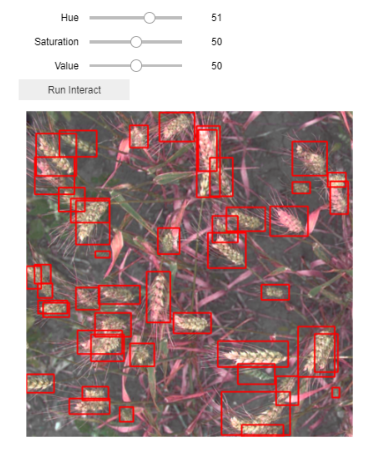

In [29]:
import matplotlib.pyplot as plt
import cv2
screenshot_dir="/kaggle/input/gwd-screenshots/"
img=cv2.imread(screenshot_dir+"image1.PNG")
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
fig,ax=plt.subplots(1,1,figsize=(16,8))
ax.set_axis_off()
ax.imshow(img)

=> Guassian Blur

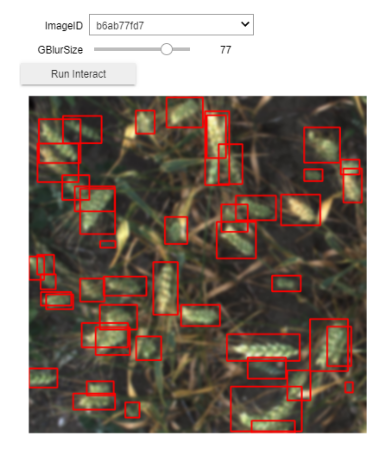

In [30]:
img=cv2.imread(screenshot_dir+"image2.PNG")
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
fig,ax=plt.subplots(1,1,figsize=(16,8))
ax.set_axis_off()
ax.imshow(img)

=>Cutout (Albumentation v/s Cutout)

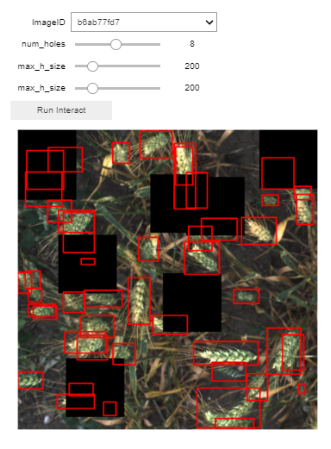

In [31]:
img=cv2.imread(screenshot_dir+"image3_1.PNG")
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
fig,ax=plt.subplots(1,1,figsize=(16,8))
ax.set_axis_off()
ax.imshow(img)

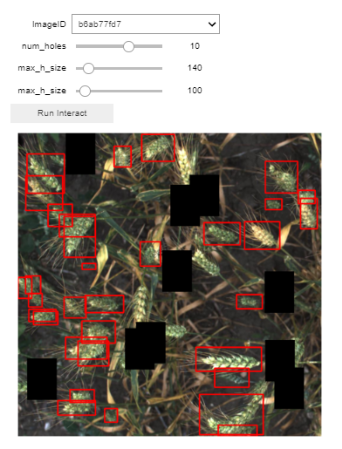

In [32]:
img=cv2.imread(screenshot_dir+"image3_2.PNG")
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
fig,ax=plt.subplots(1,1,figsize=(16,8))
ax.set_axis_off()
ax.imshow(img)

=>Custom Cutmix/Mosaic

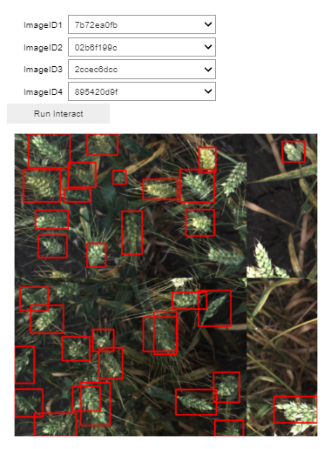

In [33]:
img=cv2.imread(screenshot_dir+"image4.PNG")
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
fig,ax=plt.subplots(1,1,figsize=(16,8))
ax.set_axis_off()
ax.imshow(img)

Post this, I hope to improve my score by incorporating it my above notebook. Thus, any feedback on this especially on the cut-out augmentations would be much appreciated

# **References**

Below helped in a great manner:

1. https://www.kaggle.com/nvnnghia/awesome-augmentation
2. https://www.kaggle.com/c/global-wheat-detection/discussion/151800
3. http://www.andrewjanowczyk.com/employing-the-albumentation-library-in-pytorch-workflows-bonus-helper-for-selecting-appropriate-values/
4. https://www.kaggle.com/kaushal2896/gwd-data-augmentation-tutorial-5-fold-split
5. https://www.kaggle.com/reighns/augmentations-data-cleaning-and-bounding-boxes

## Importing Packages

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
import matplotlib.pyplot as plt
import PIL
from PIL import Image

import cv2

import torch
import torchvision
from torchvision import transforms

import torch.utils.data
from torch.utils.data import Dataset, DataLoader
import random

import albumentations
from albumentations.pytorch.transforms import ToTensorV2

In [2]:
import ipywidgets as widgets
from ipywidgets import interact, interactive
from IPython.display import display
import plotly.graph_objects as go

In [3]:
os.listdir("/kaggle/input/global-wheat-detection")

train_dir = "/kaggle/input/global-wheat-detection/train"
test_dir = "/kaggle/input/global-wheat-detection/test"

df_train=pd.read_csv("/kaggle/input/global-wheat-detection/train.csv")

We know the structure df_train from the given data description:
1. image_id - the unique image ID
2. width, height - the width and height of the images
3. bbox - a bounding box, formatted as a Python-style list of [xmin, ymin, width, height]

bbox is something of high interest to us. We need to structure bbox in a way that can be used further

In [4]:
df_train['x0'] = df_train['bbox'].map(lambda x: x[1:-1].split(",")[0]).astype(float)
df_train['y0'] = df_train['bbox'].map(lambda x: x[1:-1].split(",")[1]).astype(float)
df_train['w'] = df_train['bbox'].map(lambda x: x[1:-1].split(",")[2]).astype(float)
df_train['h'] = df_train['bbox'].map(lambda x: x[1:-1].split(",")[3]).astype(float)
df_train['x1'] = df_train['x0'] + df_train['w']
df_train['y1'] = df_train['y0'] + df_train['h']

In [5]:
list_image_ids = list(df_train['image_id'].unique())
dict_bbox = {}
dict_labels = {}
for img_id in list_image_ids:
    dict_bbox[img_id] = df_train.loc[df_train['image_id']==img_id,['x0','y0','x1','y1']].astype(np.int32).values
    dict_labels[img_id] = np.ones((len(dict_bbox[img_id]),1),dtype=np.int32)

Incorporating some helper functions

In [6]:
def show_image(disp_image):
    fig,ax = plt.subplots(1,1,figsize=(16,8))
    ax.set_axis_off()
    ax.imshow(disp_image)

In [7]:
def load_image(image_id,img_dir=train_dir):
    ret_img = cv2.imread(img_dir+"//"+image_id+".jpg")
    ret_img = cv2.cvtColor(ret_img, cv2.COLOR_BGR2RGB)
    return ret_img

In [8]:
def load_image_bbox(disp_image,bboxes):
    ret_image = disp_image.copy()
    for box in bboxes:
        x0,y0,x1,y1 = box[0],box[1],box[2],box[3]
        cv2.rectangle(ret_image,(x0,y0),(x1,y1),(255,0,0),3)
    return ret_image

Disclaimer: There are delays sometimes when rendering the output image. This could be due to the execution load triggered by albumentations library, as it is primarily used for a batch of data. I am working on reducing these delays. If you have any ideas on the same. Please let me know.

This are the reasons why I have configured below parameters in a specific manner:
1. "continous_update" set to False.
2. introduced "interact_manual"

**1. HSV Augmentation**

In [9]:
imageid_dropdown = widgets.Dropdown(description="ImageID",value=list_image_ids[0],options=list_image_ids)
x_widget = widgets.IntSlider(min=-180, max=180, step=1, value=0, continuous_update=False, description='Hue')
y_widget = widgets.IntSlider(min=0, max=100, step=1, value=0, continuous_update=False, description='Saturation')
z_widget = widgets.IntSlider(min=0, max=100, step=1, value=0, continuous_update=False, description='Value')

def interactive_hsv(img_id, x,y,z):
    sel_image_id = img_id
    sel_image = load_image(sel_image_id)
    pascal_voc_bbox = dict_bbox[sel_image_id]
    labels = dict_labels[sel_image_id]
    alb_transformations = [albumentations.HueSaturationValue(always_apply=True, hue_shift_limit=x, sat_shift_limit=y, val_shift_limit=z)]
    alb_bbox_params = albumentations.BboxParams(format='pascal_voc',label_fields=['labels'])
    aug = albumentations.Compose(alb_transformations, bbox_params = alb_bbox_params)
    augmented_image = aug(image = sel_image, bboxes=pascal_voc_bbox, labels=labels)
    #show_image(augmented_image['image'])
    show_image(load_image_bbox(augmented_image['image'],augmented_image['bboxes']))

#widgets.interact_manual(interactive_hsv,img_id=imageid_dropdown, x=x_widget, y=y_widget, z=z_widget)
widgets.interact_manual(interactive_hsv,img_id=imageid_dropdown, x=x_widget, y=y_widget, z=z_widget)

interactive(children=(Dropdown(description='ImageID', options=('b6ab77fd7', 'b53afdf5c', '7b72ea0fb', '91c9d9c…

<function __main__.interactive_hsv(img_id, x, y, z)>

**2. Gaussian Blur**

In [16]:
imageid_dropdown = widgets.Dropdown(description="ImageID",value=list_image_ids[0],options=list_image_ids)
gblurlimit_widget = widgets.IntSlider(min=3, max=101, step=2, value=3, continuous_update=False, description='GBlurSize')

def interactive_gaussianblur(img_id, gblurlimit):
    sel_image_id = img_id
    sel_image = load_image(sel_image_id)
    pascal_voc_bbox = dict_bbox[sel_image_id]
    labels = dict_labels[sel_image_id]
    alb_transformations = [albumentations.GaussianBlur(blur_limit=gblurlimit,always_apply=False,p=1.0)]
    alb_bbox_params = albumentations.BboxParams(format='pascal_voc',label_fields=['labels'])
    aug = albumentations.Compose(alb_transformations, bbox_params = alb_bbox_params)
    augmented_image = aug(image = sel_image, bboxes=pascal_voc_bbox, labels=labels)
    #show_image(augmented_image['image'])
    show_image(load_image_bbox(augmented_image['image'],augmented_image['bboxes']))

widgets.interact_manual(interactive_gaussianblur,img_id=imageid_dropdown, gblurlimit=gblurlimit_widget)

interactive(children=(Dropdown(description='ImageID', options=('b6ab77fd7', 'b53afdf5c', '7b72ea0fb', '91c9d9c…

<function __main__.interactive_gaussianblur(img_id, gblurlimit)>

**3. Cutout**

Here lets compare the output of a.) Cutout from albumentations b.) Custom Cutout

a.)Cutout from albumentations

In [17]:
imageid_dropdown = widgets.Dropdown(description="ImageID",value=list_image_ids[0],options=list_image_ids)
numholes_widget = widgets.IntSlider(min=1, max=16, step=1, value=8, continuous_update=False, description='num_holes')
maxhsize_widget = widgets.IntSlider(min=10, max=1000, step=10, value=8, continuous_update=False, description='max_h_size')
maxwsize_widget = widgets.IntSlider(min=10, max=1000, step=10, value=8, continuous_update=False, description='max_h_size')

def interactive_cutout(img_id, numholes, maxhsize, maxwsize):
    sel_image_id = img_id
    sel_image = load_image(sel_image_id)
    pascal_voc_bbox = dict_bbox[sel_image_id]
    labels = dict_labels[sel_image_id]
    alb_transformations = [albumentations.Cutout(num_holes=numholes,max_h_size=maxhsize, max_w_size=maxwsize, fill_value=0, always_apply=False,p=1.0)]
    alb_bbox_params = albumentations.BboxParams(format='pascal_voc',label_fields=['labels'])
    aug = albumentations.Compose(alb_transformations, bbox_params = alb_bbox_params)
    augmented_image = aug(image = sel_image, bboxes=pascal_voc_bbox, labels=labels)
    #show_image(augmented_image['image'])
    show_image(load_image_bbox(augmented_image['image'],augmented_image['bboxes']))

widgets.interact_manual(interactive_cutout,img_id=imageid_dropdown,numholes=numholes_widget, maxhsize=maxhsize_widget, maxwsize=maxwsize_widget)

interactive(children=(Dropdown(description='ImageID', options=('b6ab77fd7', 'b53afdf5c', '7b72ea0fb', '91c9d9c…

<function __main__.interactive_cutout(img_id, numholes, maxhsize, maxwsize)>

Notice how the bouding boxes returned are overalapping the blacked out portions of the image

b.) Custom cutout

Lets start with a helper function

In [12]:
def generate_custom_cutout(new_image,boxes,n_holes=20,max_h_size=20,max_w_size=20,height=1024,width=1024):
    
    box_coord = []
    #box_coord=list(boxes)
    for box in boxes:
        x0,y0,x1,y1 = box[0],box[1],box[2],box[3]
        box_coord.append([x0,y0,x1,y1])

    
    temp_image = new_image.copy()
    final_list_coord = box_coord.copy()
    i=0
    for hole_ in range(n_holes):
        x = random.randint(0, 1024)
        y = random.randint(0, 1024)
        # Generating diagonally opposite co-ordinates
        y1 = np.clip(y-max_h_size // 2, 0, height)
        x1 = np.clip(x-max_w_size // 2, 0, width)
        y2 = np.clip(y1 + max_h_size, 0, height)
        x2 = np.clip(x1 + max_w_size, 0, width)
        mask = np.ones((1024,1024,3),np.int32)
        mask[y1:y2,x1:x2,:]=0
        invert_mask = 1- mask
        temp_image = temp_image * mask
        j=0
        for box in box_coord:
            j=j+1

            x0,y0,x1,y1 = box[0], box[1], box[2], box[3]
            # finding intersection
            img1 = invert_mask

            img2 = np.zeros((1024,1024,3))
            img2[y0:y1,x0:x1,:]=1


            intersection = np.logical_and(img1, img2)
            instersection_area = np.sum(intersection)

            if instersection_area>0:
                if box in final_list_coord:
                    final_list_coord.remove(box)

    ret_image={}
    ret_image['image']=temp_image
    ret_image['bboxes']=final_list_coord
    
    return ret_image

In [13]:
imageid_dropdown = widgets.Dropdown(description="ImageID",value=list_image_ids[0],options=list_image_ids)
numholes_widget = widgets.IntSlider(min=1, max=16, step=1, value=8, continuous_update=False, description='num_holes')
maxhsize_widget = widgets.IntSlider(min=10, max=1000, step=10, value=8, continuous_update=False, description='max_h_size')
maxwsize_widget = widgets.IntSlider(min=10, max=1000, step=10, value=8, continuous_update=False, description='max_h_size')

def interactive_custom_cutout(img_id, numholes, maxhsize, maxwsize):
    sel_image_id = img_id
    sel_image = load_image(sel_image_id)
    pascal_voc_bbox = dict_bbox[sel_image_id]
    labels = dict_labels[sel_image_id]
    
    augmented_image = generate_custom_cutout(sel_image,pascal_voc_bbox,n_holes=numholes,max_h_size=maxhsize,max_w_size=maxwsize,height=1024,width=1024)
    show_image(load_image_bbox(augmented_image['image'],augmented_image['bboxes']))

widgets.interact_manual(interactive_custom_cutout,img_id=imageid_dropdown,numholes=numholes_widget, maxhsize=maxhsize_widget, maxwsize=maxwsize_widget)

interactive(children=(Dropdown(description='ImageID', options=('b6ab77fd7', 'b53afdf5c', '7b72ea0fb', '91c9d9c…

<function __main__.interactive_custom_cutout(img_id, numholes, maxhsize, maxwsize)>

**4. CutoutMix/Mosaic**

This is not available in the albumentation library. Lets look at a custom implementation of the same

In [14]:
class mosaic:
    def __init__(self, image_dir,dict_boundingbox):
        self.dir = image_dir
        self.dict_bb = dict_boundingbox
    
    def load_input_image(self,image_id):
        ret_img = cv2.imread(self.dir+"//"+image_id+".jpg")
        ret_img = cv2.cvtColor(ret_img, cv2.COLOR_BGR2RGB)
        return ret_img
    
    
    def select_bboxes(self,img_x0,img_y0,img_x1,img_y1,h,w,list_bbox):
        bboxes =[]
        for box in list_bbox:
            bboxes.append([box[0],box[1],box[2],box[3]])
        
        mask_disp = np.zeros((h,w))
        mask_img = np.zeros((h,w))
        mask_disp[img_y0:img_y1,img_x0:img_x1]=1
        mask_img[img_y0:img_y1,img_x0:img_x1]=1
        
        res_bbox = [] 
        for box in bboxes:
            x0,y0,x1,y1 = int(box[0]),int(box[1]),int(box[2]),int(box[3])
            area_box = (y1-y0)*(x1-x0)

            mask_box = np.zeros((h,w))
            mask_box[y0:y1,x0:x1]=1

            intersection = np.logical_and(mask_img, mask_box)
            intersection_area = np.sum(intersection)
            if(int(intersection_area) == int(area_box)):
                res_bbox.append(box)
        return res_bbox
    
    def generate_mosaic(self,img_id1,img_id2,img_id3,img_id4):
        # for mosaic
        padding = 100
        blank_img = np.zeros((1024,1024,3))
        w_set,h_set = 1024,1024
        
        img_1,bbox_1 = self.load_input_image(img_id1),self.dict_bb[img_id1]
        
        img_2,bbox_2 = self.load_input_image(img_id2),self.dict_bb[img_id2]
        
        img_3,bbox_3 = self.load_input_image(img_id3),self.dict_bb[img_id3]
        
        img_4,bbox_4 = self.load_input_image(img_id4),self.dict_bb[img_id4]

        #Generating center coordinates
        xc = random.randint(0+padding, 1024-padding)
        yc = random.randint(0+padding, 1024-padding)
        

        # first block (top-left)
        blank_img[0:yc,0:xc,:] = img_1[0:yc,0:xc,:]
        bbox_sel_1 = self.select_bboxes(0,0,xc,yc,h_set,w_set,bbox_1)

        # second block (bottom-left)
        blank_img[yc:h_set,0:xc,:] = img_2[yc:h_set,0:xc,:]
        bbox_sel_2 = self.select_bboxes(0,yc,xc,h_set,h_set,w_set,bbox_2)

        # third corner (bottom-right)
        blank_img[yc:h_set,xc:w_set,:] = img_3[yc:h_set,xc:w_set,:]
        bbox_sel_3 = self.select_bboxes(xc,yc,w_set,h_set,h_set,w_set,bbox_3)

        # fourth corner (top-right)
        blank_img[0:yc,xc:w_set,:] = img_4[0:yc,xc:w_set,:]
        bbox_sel_4 = self.select_bboxes(xc,0,w_set,yc,h_set,w_set,bbox_4)
        ret_image = {}
        ret_image['bboxes']=bbox_sel_1+bbox_sel_2+bbox_sel_3+bbox_sel_4
        for box in ret_image['bboxes']:
            cv2.rectangle(blank_img,(box[0],box[1]),(box[2],box[3]),(255,0,0),3)
        
        ret_image['image']=blank_img.astype(np.int32)
        
        return ret_image

Please Note:Initially select a set of images or click on all 4 drop downs and select images and click on "Run Interact". If you simply click on "Run Interact" it will not show the mosaic

In [15]:
imageid1_dropdown = widgets.Dropdown(description="ImageID1",value=list_image_ids[0],options=list_image_ids)
imageid2_dropdown = widgets.Dropdown(description="ImageID2",value=list_image_ids[0],options=list_image_ids)
imageid3_dropdown = widgets.Dropdown(description="ImageID3",value=list_image_ids[0],options=list_image_ids)
imageid4_dropdown = widgets.Dropdown(description="ImageID4",value=list_image_ids[0],options=list_image_ids)


def interactive_custom_cutout(img_id1, img_id2, img_id3, img_id4):
    
    directory_of_images = "/kaggle/input/global-wheat-detection/train"
    aug_obj = mosaic(directory_of_images,dict_bbox)
    augmented_image = aug_obj.generate_mosaic(img_id1,img_id2,img_id3,img_id4)
    #augmented_image = generate_custom_cutout(sel_image,pascal_voc_bbox,n_holes=numholes,max_h_size=maxhsize,max_w_size=maxwsize,height=1024,width=1024)
    show_image(load_image_bbox(augmented_image['image'],augmented_image['bboxes']))

widgets.interact_manual(interactive_custom_cutout,img_id1=imageid1_dropdown, img_id2=imageid2_dropdown, img_id3=imageid3_dropdown, img_id4=imageid4_dropdown)

interactive(children=(Dropdown(description='ImageID1', options=('b6ab77fd7', 'b53afdf5c', '7b72ea0fb', '91c9d9…

<function __main__.interactive_custom_cutout(img_id1, img_id2, img_id3, img_id4)>

# **Conclusion**

Hope this gives an idea of how augmentations can be made in an interactive form and how tuning can be made more intuitive by this. I really hope this helps someone in one way or another.

I have not gone to the extend of incorporating all possible augmentations present in the albumentations library, as it may seem repititive. 

Again, just repeating what I mentioned earler, this interactive framework is still experimental with some delays and constraints because I am still familiarizing myself with the ipython widget. 

Also I am planning to incorporate these in my code to tune my current model below:
https://www.kaggle.com/shebinscaria/pytorch-resnet50fpn-gwd


Thus, any feedback on this, especially on the cut-out augmentations would be much appreciated